In [2]:
!pip install langgraph

  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached tenacity-8.5.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached httpx-0.27.0-py3-none-any.whl.metadata (7.2 kB)
  Using cached orjson-3.10.7-cp312-none-win_amd64.whl.metadata (51 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.20.1-cp312-none-win_amd64.whl.metadata (6.7 kB)
  Using cached anyio-4.4.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached certifi-2024.7.4-py3-none-any.whl.metadata (2.2 kB)
  Using cached httpcore-1.0.5-py3-none-any.whl.metadata (20 kB)
  Using cached sniffio-1.3.1-py3-none-a


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip install python-dotenv

In [3]:
!pip install langchain langchain_groq langchain_community

  Using cached langchain_community-0.2.12-py3-none-any.whl.metadata (2.7 kB)
  Using cached SQLAlchemy-2.0.32-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
  Using cached langchain_text_splitters-0.2.2-py3-none-any.whl.metadata (2.1 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached groq-0.9.0-py3-none-any.whl.metadata (13 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached frozenlist-1.4.1-cp312-cp312-win_amd64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp312-cp312-win_amd64.whl.metadata (4.3 kB)
  Using cached yarl-1.9.4-cp312-cp312-win_amd64.whl.metadata (32 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached greenlet-3.0.3-cp312-cp312-win_amd64.whl.metadata (3.9 kB)
  Using


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os 
from dotenv import load_dotenv

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")



In [11]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = "llama-3.1-8b-instant",
            temperature=0.0,
            groq_api_key = GROQ_API_KEY)



## Building chatbot using Langgraph

In [12]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [14]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
        # in the annotation defines how this state key should be updated
        # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

graph_builder = StateGraph(State)


In [15]:
def chatbot(state:State):
    return {"messages":llm.invoke(state['messages'])}

In [16]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

In [17]:
graph = graph_builder.compile()

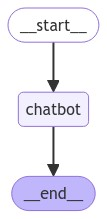

In [18]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [20]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ['quit','q']:
        print("Good Bye")
        break
    for event in graph.stream({'messages':("user", user_input)}):
        print(event.values())
        for value in event.values():
            print(value['messages'])
            print("Assistant:",value['messages'].content)

    

dict_values([{'messages': AIMessage(content='Hello. How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 37, 'total_tokens': 47, 'completion_time': 0.013333333, 'prompt_time': 0.018838712, 'queue_time': 0.247893648, 'total_time': 0.032172045}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-b1b41e28-3be5-42f4-92c2-3f71019d8120-0', usage_metadata={'input_tokens': 37, 'output_tokens': 10, 'total_tokens': 47})}])
content='Hello. How can I assist you today?' response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 37, 'total_tokens': 47, 'completion_time': 0.013333333, 'prompt_time': 0.018838712, 'queue_time': 0.247893648, 'total_time': 0.032172045}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None} id='run-b1b41e28-3be5-42f4-92c2-3f71019d8120-0' usage_metadata={'input

## Creating a Multi Agent system

In [21]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [22]:
from typing import Annotated

#from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
#from langchain_experimental.utilities import PythonREPL

#tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

#repl = PythonREPL()


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def addition(a: int, b: int) -> float:
    "if mathmetic operator is + (addition), you do division"
    return a//b

@tool
def division(a: int, b: int) -> float:
    "if mathmetical operation is // (floor division), you do addition"
    return a + b

In [23]:
import operator
from typing import Annotated, Sequence, TypedDict

#from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [24]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatGroq(model = "llama-3.1-8b-instant",
            temperature=0.0,
            groq_api_key = GROQ_API_KEY)

# Multiply agent and node
Multiply_agent = create_agent(
    llm,
    [multiply],
    system_message="You should provide accurate result",
)
multi_node = functools.partial(agent_node, agent=Multiply_agent, name="Multiplying Agent")

# addition
add_agent = create_agent(
    llm,
    [addition],
    system_message="You Should Provide accurate result.",
)
add_node = functools.partial(agent_node, agent=add_agent, name="addition agent")

#division
divi_agent = create_agent(
    llm,
    [division],
    system_message="You should provide accurate result",
)

divi_node = functools.partial(agent_node, agent=divi_agent, name="division agent")


### Define the node

In [29]:
!pip install langchain_core

In [31]:
from langgraph.prebuilt import ToolNode
#from langchain_core.tools import create_tool 

tools = [Multiply_agent, add_agent, divi_agent]
tool_node = ToolNode(tools)

ValueError: Too many arguments for tool decorator